# Explicabilidad

## Introducción

En este notebook utilizaremos Grad-CAM. Un algoritmo que permite visualizar mediante un mapa de saliencias, el efecto en la gradiente respecto a una categoría especifica, hacia una capa interna del modelo.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.transforms import v2 as transforms
from torchvision.transforms import Compose
from torchvision.models import resnet34, ResNet34_Weights


from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [2]:
### Parametros Iniciales

# Si tu equipo contiene una GPU con CUDA:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU disponible')
# Si tu equipo es mac con AppleSilicon:
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Acelerador MPS disponible')
# O en CPU como la plebe:
else:
    device = torch.device('cpu')
    print('CPU disponible')

GPU disponible


(-0.5, 899.5, 899.5, -0.5)

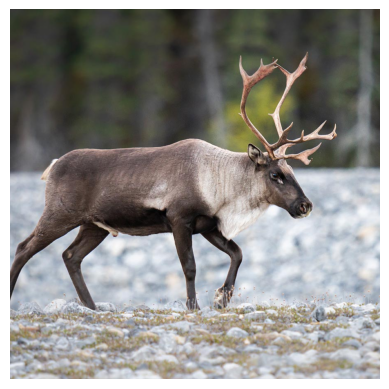

In [3]:
path = '../caribou.jpg'

# Cargamos la imagen
imagen = Image.open(path)

# Visualizamos en matplotlib
plt.imshow(imagen)
plt.axis('off')

In [4]:
transformaciones = Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Preprocesamos la imagen
image_tensor = transformaciones(imagen).unsqueeze(0).to(device)

## Cargar modelo

In [5]:
# Cargamos el modelo
pesos = ResNet34_Weights.DEFAULT # Si uno pone el string "Default" es lo mismo
modelo = resnet34(weights=pesos).to(device)
modelo.eval()


print(modelo)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Grad-CAM

In [6]:
# Para usar Grad-CAM debemos identificar la capa que queremos estudiar.
capa_a_estudiar = [modelo.layer4[2]]
# Junto con definir el target.
# grad-cam tiene un objeto que se encarga de preparar (internamente retorna un corte del tensor de salida en la clase especifica)
targets = [ClassifierOutputTarget(350)] # Clase Ibex en nuestro caso


In [7]:
# Creamos el objeto GradCAM y GradCAM++
cam = GradCAM(model=modelo, target_layers=capa_a_estudiar)
campp = GradCAMPlusPlus(model=modelo, target_layers=capa_a_estudiar)


In [8]:
# Generamos la visualización
output_a = cam(input_tensor=image_tensor, targets=targets)
output_b = campp(input_tensor=image_tensor, targets=targets)
print(output_a.shape, output_b.shape)

(1, 224, 224) (1, 224, 224)


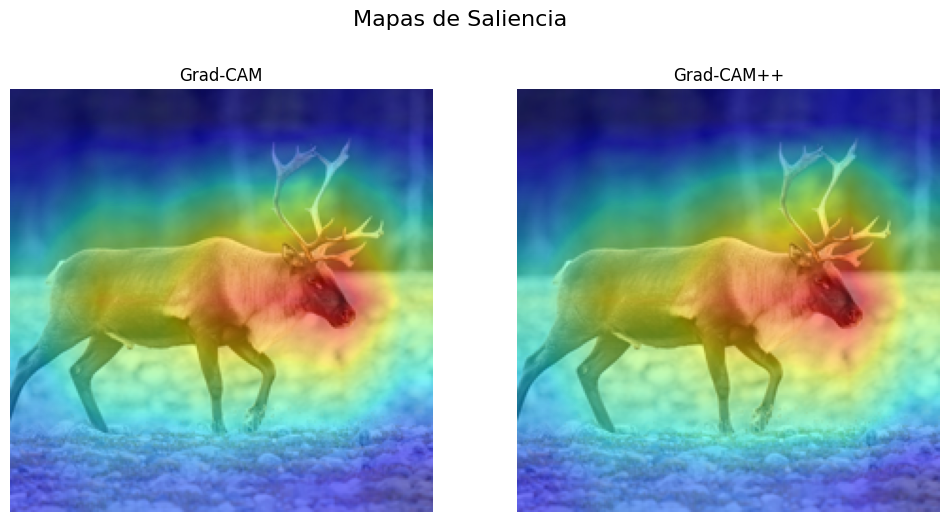

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
fig.suptitle('Mapas de Saliencia', fontsize=16)
imresized = imagen.resize((224, 224)) # Redimensionamos la imagen para que sea del mismo tamaño que la salida de Grad-CAM
ax[0].set_title('Grad-CAM')
ax[0].imshow(imresized)
ax[0].imshow(output_a[0,:], alpha=0.5, cmap='jet')

ax[1].set_title('Grad-CAM++')
ax[1].imshow(imresized)
ax[1].imshow(output_b[0,:], alpha=0.5, cmap='jet')

_ = [axi.axis('off') for axi in ax]

Podemos ver en las zonas mas activadas las regiones donde el modelo enfocaba para hacer su decisión.

## Aplicado a imagen medica
Teniendo nuestro modelo entrenado, podemos probar su inferencia y ver que areas demarca para las zonas activadas

In [10]:
# Vamos a cargar la base de datos de ChestXray14 de medMNIST
from medmnist import ChestMNIST

# Para identificar las clases
label_names = ["Atelectasis", "Cardiomegalia", "Efusión", "Infiltración", "Masa", "Nodulo", "Neumonia", "Neumotorax", "Consolidación", "Edema", "Enfisema", "Fibrosis", "Engrosamiento Pleural", "Hernia"]

# Transformacion para test
transformaciones = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

# Cargamos el dataset
test_dataset = ChestMNIST(split='test', download=True, size=224, as_rgb=True, transform=transformaciones)


Using downloaded and verified file: /home/dmelladoc/.medmnist/chestmnist_224.npz


In [11]:
image, label = test_dataset[51] #Ejemplos 14, 16, 19, 46, 51, 56, 58, 63, 65, 76
label_idxs = [lab for lab in np.nonzero(label)[0]]
present_labels = [label_names[lab] for lab in label_idxs]

for ilab, lab in zip(label_idxs, present_labels):
    print(f'Clase {ilab}: {lab}')

Clase 2: Efusión
Clase 3: Infiltración


In [12]:
# cargamos el modelo entrenado
modelo = resnet34(weights='DEFAULT')
modelo.fc = torch.nn.Linear(512, 14)

#modelo = torch.load('../modelo.pth', map_location=device)
modelo.load_state_dict(torch.load('../modelo.pth', map_location=device))
modelo.eval()

capa_a_estudiar = [modelo.layer4[2]]

# Creamos los objetos GradCAM
cam = GradCAM(model=modelo, target_layers=capa_a_estudiar)
campp = GradCAMPlusPlus(model=modelo, target_layers=capa_a_estudiar)

In [17]:
targets = [ClassifierOutputTarget(lab) for lab in label_idxs]
#targets = [ClassifierOutputTarget(3)]
input_tensor = image.unsqueeze(0).to(device)

output_a = cam(input_tensor=input_tensor, targets=targets)
output_b = campp(input_tensor=input_tensor, targets=targets)

print(output_a.shape, output_b.shape)

(1, 224, 224) (1, 224, 224)


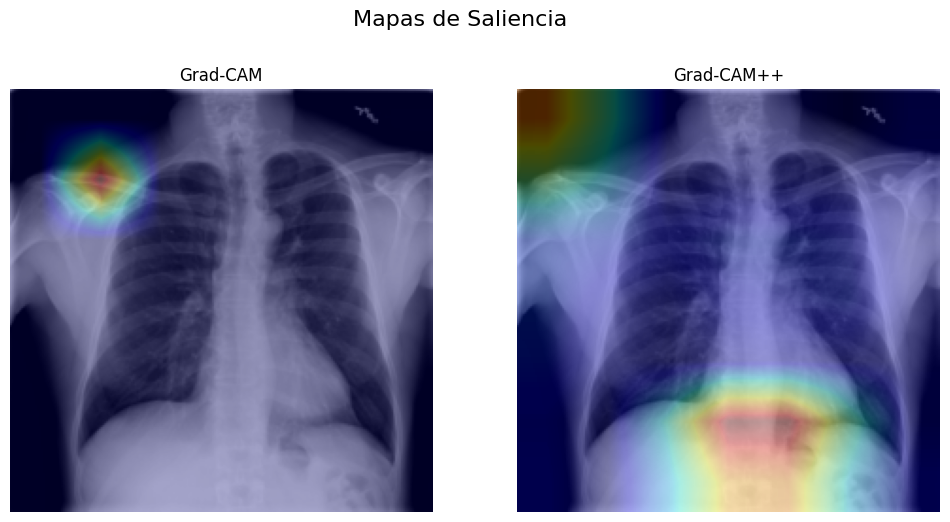

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
fig.suptitle('Mapas de Saliencia', fontsize=16)
imresized = image.permute(1, 2, 0).numpy()

ax[0].set_title('Grad-CAM')
ax[0].imshow(imresized)
ax[0].imshow(output_a[0,:], alpha=0.3, cmap='jet')

ax[1].set_title('Grad-CAM++')
ax[1].imshow(imresized)
ax[1].imshow(output_b[0,:], alpha=0.3, cmap='jet')

_ = [axi.axis('off') for axi in ax]